# Image convolution

## 0. Key take-aways

Key take-aways should be:
* Many operations in image processing are independent between pixel and easily parallizable (embarassingly parallel). Therefore they map well to GPU, where operations on each pixel is mapped to single CUDA thread.
* Data transfer from the host to GPU device takes time.
* Example usage of different types of memory on the GPU in Numba:
  * global memory
  * constant memory
  * shared memory

## 1. Introduction and motivation

Convolution is a central operation in image processing, where the input image is processed with a mask (also called kernel or convolution matrix) to yield the output image.

Depending on the mask that is used, we can e.g. blur or sharpen the images, detect edges or detect similarity between the mask and image regions (i.e. cross-correlation).

Here is an illustration of how single image-pixel is processed with a normalized, uniform mask. This smooths the input image:



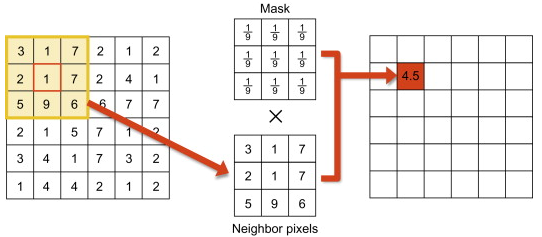


The discrete convolution can be computed as


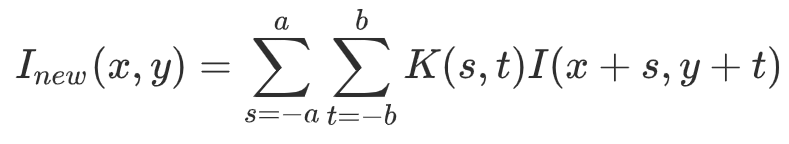


where K(s,t) is the kernel, I(x,y) is the original and image I<sub>new</sub>(x,y) is the resulting filtered image. In the example above, K is the uniform-filter with shape 3x3. Each pixel in I<sub>new</sub>(x,y) is the result of the sum over all neighborhood-pixels (as defined by the filter-size) multiplied (weighted) with its corresponding filter value.

Things to note:
* For the examples below it is helpful to interpret convolution in two ways:
  1. It calculates similarity of the mask and the image-region centered around the pixel (e.g. edge-detection).
  2. It "diffuses" local information of pixels to neighboring pixels (e.g. blurring with uniform mask).
* Since the final pixel value in depends only on its neighborhood and the (fixed) values in the kernel, **this operation can be run in parallel for each pixel**.
* **The size of the _valid_ output image is smaller than the input image**: For a MxM image and NxN filter (with uneven N) we can only compute output pixel-values within the area M-(N-1)/2 x M-(N-1)/2 of the input image. This is because to obtain valid pixel values the filter must lie fully inside the input-image.


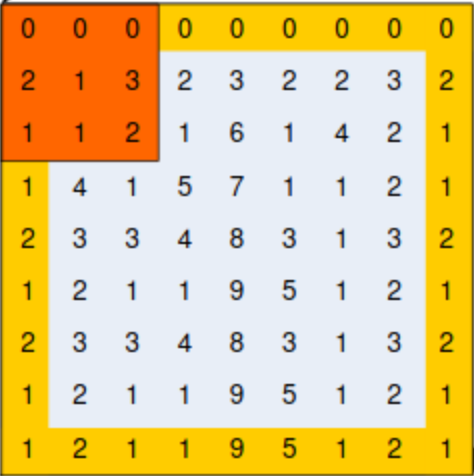


Some examples using convolution:

### 1.1. Example 1: Vertical edge-detection with Sobel-v filter

Here is an example of edge detection using the Sobel filter:


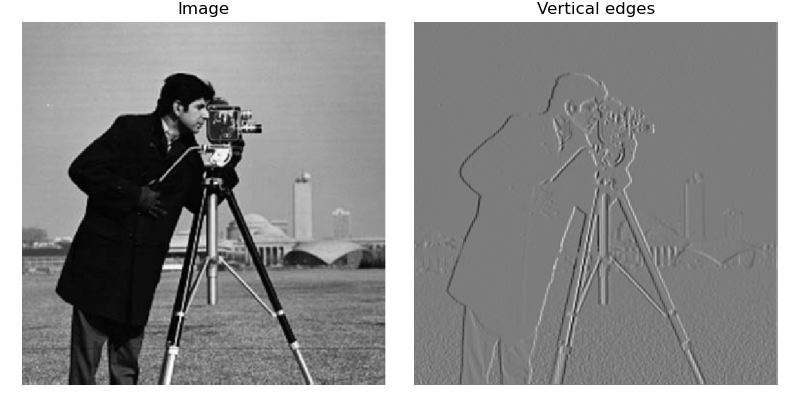


Here we used the Sobel-V filter to detect vertical edges in an image. The operation is defined as


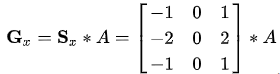


where the Sobel filter S<sub>x</sub> in x-direction is convolved with the image A resulting in the approximate gradient G<sub>x</sub> in x-direction.

Sources:
[1](https://www.sciencedirect.com/topics/computer-science/linear-convolution)
[2](https://en.wikipedia.org/wiki/Sobel_operator)

### 1.2. Example 2: Smoothing with uniform filter

Here is an example of the effect of the uniform filter discussed above. It blurs/smooths the image. Smoothing operations can be helpful to reduce image noise (but they reduce resolution as well).

This is the example that we will look at below.

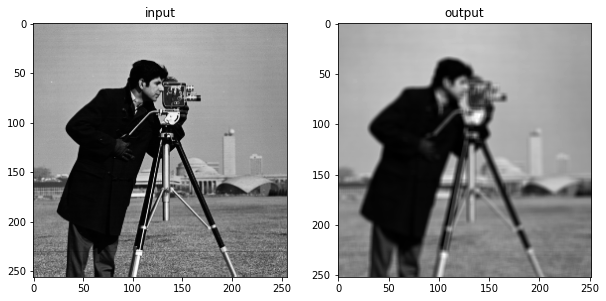

In [ ]:
import numpy as np
from scipy.signal import convolve2d
from skimage import io
import matplotlib.pyplot as plt

image_path = "https://homepages.cae.wisc.edu/~ece533/images/cameraman.tif"
image = io.imread(image_path).astype(np.float32)
filter_shape = (5, 5)
uniform_filter = np.ones(filter_shape)/sum(np.ones(filter_shape).flatten())  # create uniform 3x3 filter

filtered_image = convolve2d(image, uniform_filter, mode='valid')  # filter image using the scipy.signal.convolve2d

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input')
ax[1].imshow(filtered_image, cmap='gray')
ax[1].set_title('output')
plt.show()

## 2.1. Preparation: Output GPU information

In [ ]:
# report the GPUs in the system
!echo "CPU:"
!cat /proc/cpuinfo | grep name
!echo "GPU:"
!nvidia-smi

CPU:
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
model name	: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
GPU:
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for
       usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for
       usage information.

Mon Feb  1 23:33:44 2021    

### 2.1. Preparation: Define support functions and image path

In [ ]:
import time
import numpy as np
from numba import jit, njit, prange, cuda, float32
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import io


""" URL of the image that we will process below """
image_path = "https://homepages.cae.wisc.edu/~ece533/images/cameraman.tif"
# image_path = "./cameraman.tif"


def read_image(image_path, tiles_per_dimension=1):
    """
    read and normalized image and return image
    with tiles_per_dimension tiles per dimension
    """
    image = io.imread(image_path).astype(np.float32)
    image -= np.min(image)
    image /= np.max(image)
    image = np.tile(image, (tiles_per_dimension, tiles_per_dimension))
    return image


def keep_valid_image(filtered_image, filter):
    """
    using the filter-size determined from filter array
    and the size of the filtered image return only valid area
    of the filtered image.
    """
    filter_height, filter_width = filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2
    return filtered_image[filter_height_halved:-filter_height_halved,
           filter_width_halved:-filter_width_halved]


def get_blocks_per_grid(threads_per_block, image_shape):
    """
    get the number of blocks per x-/y-dimension depending
    on number of pixels per dimension (image_shape) and
    and the number of threads in a block (threads_per_block)
    """
    griddim = (image_shape[0] // threads_per_block[0] + 1, image_shape[1] // threads_per_block[1] + 1)
    return griddim


from contextlib import contextmanager


@contextmanager
def timeit_context(name, repeats=1):
    """
    context function for timing the execution time of implementations
    """
    startTime = time.time()
    for ind in range(repeats):
        yield
    elapsedTime = time.time() - startTime
    print(f"{name} is {elapsedTime * 1000. / repeats:.2f} ms")


def timeit(func_to_time, repeats=1):
    """
    time the execution of func_to_time averaging over given number of repeats
    """
    from time import perf_counter
    func_to_time()  # execute once to setup JIT/compile and load CUDA kernel, so that this does not affect timing
    start = perf_counter()
    for count in range(repeats):
        func_to_time()
    stop = perf_counter()
    avg_run_time_ms = 1000 * (stop - start) / repeats
    return avg_run_time_ms


def get_uniform_filter(size):
    """
    return a rectangular, uniform filter of give size
    """
    return np.ones((size, size)).astype(np.float32) / size ** 2


def measure_exec_time_for_parameter_range(callback, parameter_range, repeats_per_measurement=1):
    """
    measure execution time using timeit for a give parameter range
    """
    timeit_result = []
    for parameter in parameter_range:
        timeit_result.append(timeit(lambda: callback(parameter), repeats=repeats_per_measurement))
    return np.array(timeit_result)


def validate_result_against_scipy_implementation(actual_filtered_image, image, filter):
    """
    validate that the result is identical to that from scipy.signal.convolve2d, which we use as reference implementation
    """
    reference_filtered_image = convolve2d(image, filter, mode='valid')
    np.testing.assert_almost_equal(actual_filtered_image, reference_filtered_image)
    
    
def plot_exec_times_comparison(filter_size,
                                exec_times_slower, label_0,
                                exec_times_faster, label_1):
    """
    plot performance comparison; this is a convenience function for comparing execution times for different filter-size and implementations
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(filter_size, exec_times_slower, label=label_0)
    ax[0].plot(filter_size, exec_times_faster, label=label_1)
    ax[0].legend()
    ax[0].set_xlabel('filter size')
    ax[0].set_ylabel('execution time [ms]')

    ratio = exec_times_slower / exec_times_faster
    ax[1].plot(filter_size, ratio, label='speedup')
    ax[1].legend()
    ax[1].set_xlabel('filter size')
    ax[1].set_ylabel('relative speedup')
    ax[1].set_ylim([0, np.max(ratio) + 0.1 * np.max(ratio)])
    plt.show()

### 4. Custom CPU implementation

Here is a custom CPU version of the 2D convolution function using Numba JIT.

In [ ]:
# CPU convolution definition using Numba JIT without parallelization.
@jit(nopython=True)
def convolve_cpu_jit(image, filter, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    for row in range(0, image_height):  # iterate over pixel rows
        for col in range(0, image_width):  # iterate over pixel columns
            if row < filter_height_halved or row >= image_height - filter_height_halved:  # do nothing if outside valid area of image
                continue
            if col < filter_width_halved or col >= image_width - filter_width_halved:  # do nothing if outside valid area of image
                continue
            
            # calculate convolution for each pair (row, col)
            filtered_value = 0.0
            for conv_index_y in range(-filter_height_halved,
                                      filter_height_halved + 1):  # iterate over filter rows
                for conv_index_x in range(-filter_width_halved,
                                          filter_width_halved + 1):  # iterate over filter columns
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    filtered_value += filter[kernelCoord] * image[imageCoord]  # multiply and sum to obtain convolution
            result[row, col] = filtered_value

In [ ]:
# CPU convolution definition using parallelization with prange; this implementation runs in parallel on a multi-core CPU.
# It is 6x faster than the `filter2d_cpu_jit` version on my 6-core laptop.
@njit(parallel=True)
def convolve_cpu_prange(image, filter, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    # calculate convolution for each pair (row, col)
    for row in prange(0, image_height):  # iterate over pixel rows using prange for parallelization
        for col in range(0, image_width):  # iterate over pixel columns
            if row < filter_height_halved or row >= image_height - filter_height_halved:  # do nothing if outside valid area of image
                continue
            if col < filter_width_halved or col >= image_width - filter_width_halved:  # do nothing if outside valid area of image
                continue

            filtered_value = 0.0
            for conv_index_y in range(-filter_height_halved,
                                      filter_height_halved + 1):  # iterate over filter rows
                for conv_index_x in range(-filter_width_halved,
                                          filter_width_halved + 1):  # iterate over filter columns
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    filtered_value += filter[kernelCoord] * image[imageCoord]  # multiply and sum to obtain convolution
            result[row, col] = filtered_value

Compare performance of the two CPU implementations ...

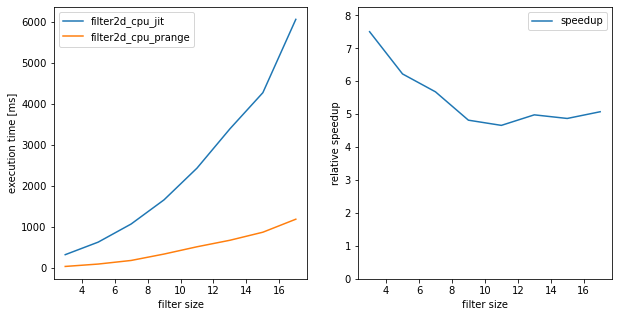

In [ ]:
# read image
image = read_image(image_path, 1)

# confirm that the numba implementations return same result as scipy.signal.convolve2d(..., mode='valid')
filter = get_uniform_filter(size=3)
filtered_image = np.zeros_like(image)

convolve_cpu_prange(image, filter, filtered_image)
result = keep_valid_image(filtered_image, filter)
validate_result_against_scipy_implementation(result, image, filter)

convolve_cpu_jit(image, filter, filtered_image)
result = keep_valid_image(filtered_image, filter)
validate_result_against_scipy_implementation(result, image, filter)

# compare performance
image = read_image(image_path, 16)
filtered_image = np.zeros_like(image)

filter_sizes = [3, 5, 7, 9, 11, 13, 15, 17]

uniform_filters = [get_uniform_filter(size) for size in filter_sizes]

def convolve_cpu_jit_timeit_callback(filter):
    convolve_cpu_jit(image, filter, filtered_image)

exec_times_convolve_cpu_jit = measure_exec_time_for_parameter_range(convolve_cpu_jit_timeit_callback, uniform_filters, repeats_per_measurement=1)

def convolve_cpu_prange_timeit_callback(filter):
    convolve_cpu_prange(image, filter, filtered_image)

exec_times_convolve_cpu_prange = measure_exec_time_for_parameter_range(convolve_cpu_prange_timeit_callback, uniform_filters, repeats_per_measurement=1)

plot_exec_times_comparison(filter_sizes,
                            exec_times_convolve_cpu_jit, 'filter2d_cpu_jit',
                            exec_times_convolve_cpu_prange, 'filter2d_cpu_prange')

`exec_times_convolve_cpu_prange` is 5x to 7x faster than single-core version `exec_times_convolve_cpu_jit` on my 6-core laptop.

Both yield the same result as Scikit-Image.

## 5. Naive CUDA implementation

Now let's rewrite `convolve_cpu_jit` as a CUDA kernel and compare its performance:

To convert it into a CUDA-kernel we:
* replace the outer loops that iterate over pixel positions with thread-indexes
* replace the `continue` with a `return` statement. This way any thread outside of the image, will return immediately.

In [ ]:
def construct_convolve_gpu_naive():
    @cuda.jit
    def convolve_gpu_naive(image, filter, result):
        image_height, image_width = image.shape
        filter_height, filter_width = filter.shape
        filter_height_halved = filter_height // 2
        filter_width_halved = filter_width // 2

        row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y  # for loop over pixel rows is replaced by y-thread index
        col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x  # for loop over pixel columns is replaced by x-thread index

        if row < filter_height_halved or row >= image_height - filter_height_halved:  # threads do nothing if outside valid area of image
            return
        if col < filter_width_halved or col >= image_width - filter_width_halved:   # threads do nothing if outside valid area of image
            return

        filtered_value = 0.0
        for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):  # iterate over filter rows
            for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):  # iterate over filter columns
                kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                imageCoord = row + conv_index_y, col + conv_index_x
                filtered_value += filter[kernelCoord] * image[imageCoord]  # multiply and sum to obtain convolution
        result[row, col] = filtered_value

    return convolve_gpu_naive

Compare performance of the CPU implementation for a single image ...

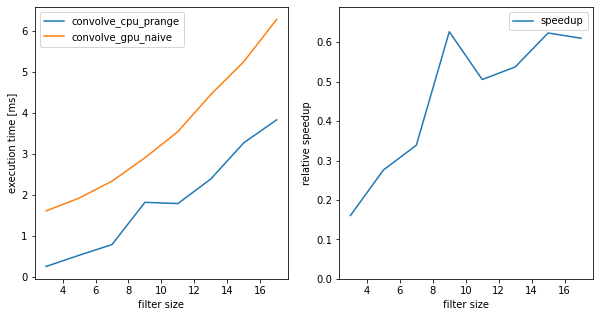

In [ ]:
image = read_image(image_path, 1)

# kernel execution settings
threads_per_block = (32, 32)

# confirm that the numba implementation return same result as scipy.signal.convolve2d(..., mode='valid')

filter = get_uniform_filter(size=3)
filtered_image = np.zeros_like(image)

blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

convolve_gpu_naive = construct_convolve_gpu_naive()
convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)

result = keep_valid_image(filtered_image, filter)
validate_result_against_scipy_implementation(result, image, filter)

# compare performance
filtered_image = np.zeros_like(image)

filter_sizes = [3, 5, 7, 9, 11, 13, 15, 17]

uniform_filters = [get_uniform_filter(size) for size in filter_sizes]

def convolve_cpu_prange_timeit_callback(filter):
    convolve_cpu_prange(image, filter, filtered_image)

exec_times_convolve_cpu_prange = measure_exec_time_for_parameter_range(convolve_cpu_prange_timeit_callback, uniform_filters, repeats_per_measurement=5)

def convolve_gpu_naive_timeit_callback(filter):
    convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)
    cuda.synchronize()

exec_times_convolve_gpu_naive = measure_exec_time_for_parameter_range(convolve_gpu_naive_timeit_callback, uniform_filters, repeats_per_measurement=5)

plot_exec_times_comparison(filter_sizes,
                            exec_times_convolve_cpu_prange, 'convolve_cpu_prange',
                            exec_times_convolve_gpu_naive, 'convolve_gpu_naive')

Here the GPU implementation `convolve_gpu_naive` is *slower* than the CPU `convolve_cpu_prange` (depending on the GPU speed, it will only be slower for the smallest filter-sizes).

But what happens for larger images?

Let's try a 16x16 tiling of the image. This corresponds to an image size of 4096x4096 pixels ...

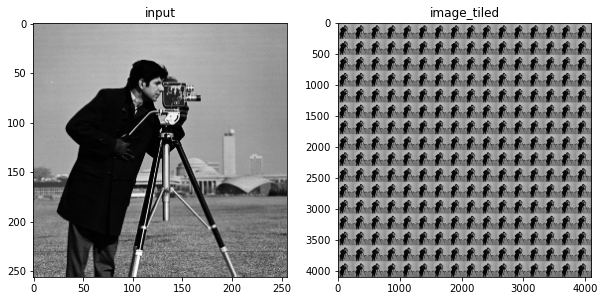

In [ ]:
# image tiling illustration

image_single = read_image(image_path, tiles_per_dimension=1)
image_tiled = read_image(image_path, tiles_per_dimension=16)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_single, cmap='gray')
ax[0].set_title('input')
ax[1].imshow(image_tiled, cmap='gray')
ax[1].set_title('image_tiled')
plt.show()

Let's profile with this 4096x496 image:

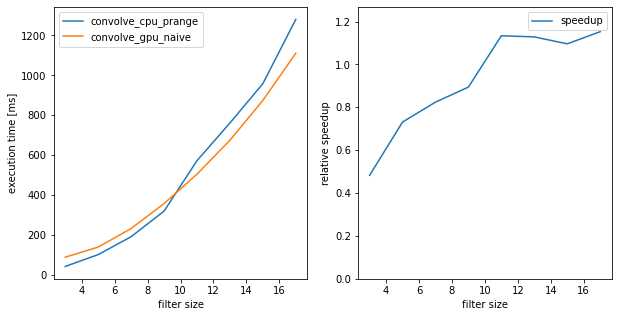

In [ ]:
image = read_image(image_path, 16)

# kernel execution settings
threads_per_block = (32, 32)

# confirm that the numba implementation return same result as scipy.signal.convolve2d(..., mode='valid')
filter = get_uniform_filter(size=3)
filtered_image = np.zeros_like(image)

blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

convolve_gpu_naive = construct_convolve_gpu_naive()
convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)

result = keep_valid_image(filtered_image, filter)
validate_result_against_scipy_implementation(result, image, filter)

# compare performance
filtered_image = np.zeros_like(image)

filter_sizes = [3, 5, 7, 9, 11, 13, 15, 17]

uniform_filters = [get_uniform_filter(size) for size in filter_sizes]

def convolve_cpu_prange_timeit_callback(filter):
    convolve_cpu_prange(image, filter, filtered_image)

exec_times_convolve_cpu_prange = measure_exec_time_for_parameter_range(convolve_cpu_prange_timeit_callback, uniform_filters, repeats_per_measurement=1)

def convolve_gpu_naive_timeit_callback(filter):
    convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)
    cuda.synchronize()

exec_times_convolve_gpu_naive = measure_exec_time_for_parameter_range(convolve_gpu_naive_timeit_callback, uniform_filters, repeats_per_measurement=3)

plot_exec_times_comparison(filter_sizes,
                            exec_times_convolve_cpu_prange, 'convolve_cpu_prange',
                            exec_times_convolve_gpu_naive, 'convolve_gpu_naive')

For a large images and filter-sizes the GPU is faster than the CPU.

The reason for the missing speed-up for small images and filter-sizes is the time spent on memory transfer to/from the GPU device.

Let's compare the time spent on data transfer and GPU computation for the smallest filter size=3.

In [ ]:
image = read_image(image_path, 1)

# kernel execution settings
threads_per_block = (32, 32)

# get filter size=3
filter = get_uniform_filter(size=3)
filtered_image = np.zeros_like(image)

blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

convolve_gpu_naive = construct_convolve_gpu_naive()
convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)
with timeit_context('GPU time including transfer'):
    convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)
    cuda.synchronize()

print("")

# copy to arrays to device memory before processing
stream = cuda.stream()
with timeit_context('Transfer time to GPU'):
    image_on_device = cuda.to_device(image, stream=stream)
    filter_on_device = cuda.to_device(filter, stream=stream)
    filtered_image_on_device = cuda.to_device(filtered_image, stream=stream)
    cuda.synchronize()

with timeit_context('GPU processing time without transfer'):
    convolve_gpu_naive[blocks_per_grid, threads_per_block](image_on_device, filter_on_device, filtered_image_on_device)
    cuda.synchronize()

# copy back the filtered image from deivce
with timeit_context('Transfer time from GPU'):
    filtered_image_on_host = filtered_image_on_device.copy_to_host()
    cuda.synchronize()

GPU time including transfer is 1.50 ms

Transfer time to GPU is 1.11 ms
GPU processing time without transfer is 0.75 ms
Transfer time from GPU is 0.32 ms


For the smallest image and filter we spend more time on transfering data to the GPU than on the computation itself.

Conclusions:

* A workload/computation must be sufficiently heavy in order to compensate the time spent on data transfer to the device and benefit from the speed-up on GPU.
* For computations consisting of multiple CUDA kernels, we should try to keep processed data in the device memory for as long possible and avoid unnecessary data-transfer from/to host.
* It is possible to have perform simultaneous data-transfer to/from the device and calculation using multiple CUDA streams. This is shown in the example "smooth particle hydrodynamics".

----

**Note: From now on we will exclude data-transfer to/from the device and only measure the actual execution-time of the kernel. This makes it easier to compare different kernel implementations.**

----

## 6. Semi-naive CUDA kernel

There are still some minor improvements we can do to the naive CUDA kernel. These are:

* Precompute all constant values `filter_height_halved` and `filter_width_halved`.
* Use `float32` for all computations.

In [ ]:
def construct_convolve_gpu_semi_naive(image_shape, filter_shape):
    image_height, image_width = image_shape
    filter_height, filter_width = filter_shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    @cuda.jit
    def convolve_gpu_semi_naive(image, filter, result):
        row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y  # for loop over pixel rows is replaced by y-thread index
        col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x  # for loop over pixel columns is replaced by x-thread index

        if row < filter_height_halved or row >= image_height - filter_height_halved:  # threads do nothing if outside valid area of image
            return
        if col < filter_width_halved or col >= image_width - filter_width_halved:   # threads do nothing if outside valid area of image
            return

        filtered_value = float32(0.0)
        for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):  # iterate over filter rows
            for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):  # iterate over filter columns
                kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                imageCoord = row + conv_index_y, col + conv_index_x
                filtered_value += filter[kernelCoord] * image[imageCoord]  # multiply and sum to obtain convolution
        result[row, col] = filtered_value

    return convolve_gpu_semi_naive

Compare naive and semi-naive implementations:

Transfer time to GPU is 13.98 ms


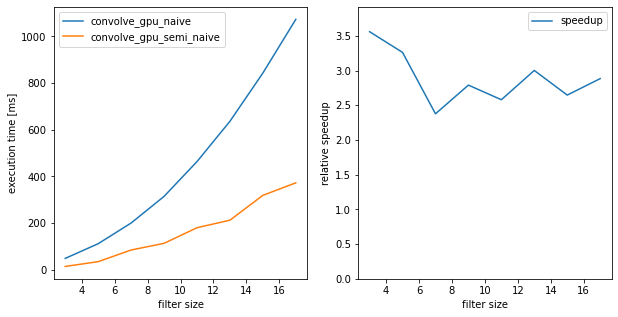

In [ ]:
image = read_image(image_path, 16)

# kernel execution settings
threads_per_block = (32, 32)

# confirm that the numba implementation return same result as scipy.signal.convolve2d(..., mode='valid')
filter = get_uniform_filter(size=3)
filtered_image = np.zeros_like(image)

blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

convolve_gpu_naive = construct_convolve_gpu_naive()
convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)

result = keep_valid_image(filtered_image, filter)
validate_result_against_scipy_implementation(result, image, filter)

# compare performance
filtered_image = np.zeros_like(image)

filter_sizes = [3, 5, 7, 9, 11, 13, 15, 17]

uniform_filters = [get_uniform_filter(size) for size in filter_sizes]

stream = cuda.stream()
with timeit_context('Transfer time to GPU'):
    image_on_device = cuda.to_device(image, stream=stream)
    filter_on_device = cuda.to_device(filter, stream=stream)
    filtered_image_on_device = cuda.to_device(filtered_image, stream=stream)
    cuda.synchronize()


timeit_result = []
for filter in uniform_filters:
    filter_on_device = cuda.to_device(filter, stream=stream)
    cuda.synchronize()
    convolve_gpu_naive = construct_convolve_gpu_naive()
    def execute(filter_arg):
        convolve_gpu_naive[blocks_per_grid, threads_per_block](image_on_device, filter_arg, filtered_image_on_device)
        cuda.synchronize()
    timeit_result.append(timeit(lambda: execute(filter_on_device), repeats=3))
exec_times_convolve_gpu_naive = np.array(timeit_result)


timeit_result = []
for filter in uniform_filters:
    filter_on_device = cuda.to_device(filter, stream=stream)
    cuda.synchronize()
    convolve_gpu_semi_naive = construct_convolve_gpu_semi_naive(image.shape, filter.shape)
    def execute(filter_arg):
        convolve_gpu_semi_naive[blocks_per_grid, threads_per_block](image_on_device, filter_arg, filtered_image_on_device)
        cuda.synchronize()
    timeit_result.append(timeit(lambda: execute(filter_on_device), repeats=3))
exec_times_convolve_gpu_semi_naive = np.array(timeit_result)

# %% compare performance
plot_exec_times_comparison(filter_sizes,
                            exec_times_convolve_gpu_naive, 'convolve_gpu_naive',
                            exec_times_convolve_gpu_semi_naive, 'convolve_gpu_semi_naive')

Conclusion:

The semi-naive version primarily faster because we specify a type for `filtered_value`:
   ```
   filtered_value = float32(0.0)
   ```
This ensures that the addition `filtered_value += filter[kernelCoord] * image[imageCoord]` will be a `float32` operation. Setting `filtered_value = 0.0`, makes `filtered_value` of type double (`float64`). This makes the calculation a double operation, which is significanlty slower, because GPUs have less single-precision than double-precision ALUs.

## 6. CUDA kernel with constant memory

Let's try to improve performance by using constant memory of the GPU:

Constant memory is a small (e.g. ~64kB), cached part of global memory that is accessible from all threads and faster than global memory due to the caching.

It is assigned by the host to the GPU and consant during kernel execution. It is a good fit for our filter-array, which stays constant during processing.

In [ ]:
def construct_convolve_gpu_const_mem(image_shape, filter):
    image_height, image_width = image_shape
    filter_height, filter_width = filter.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    # kernel definition
    @cuda.jit
    def convolve_gpu_const_mem(image, result):
        const_filter = cuda.const.array_like(filter)  # assign mask in host-memory as constant memory on GPU

        row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y  # for loop over pixel rows is replaced by y-thread index
        col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x  # for loop over pixel columns is replaced by x-thread index

        if row < filter_height_halved or row >= image_height - filter_height_halved:  # threads do nothing if outside valid area of image
            return
        if col < filter_width_halved or col >= image_width - filter_width_halved:   # threads do nothing if outside valid area of image
            return

        filtered_value = float32(0.0)
        for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):  # iterate over filter rows
            for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):  # iterate over filter columns
                kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                imageCoord = row + conv_index_y, col + conv_index_x
                filtered_value += const_filter[kernelCoord] * image[imageCoord]  # multiply and sum to obtain convolution
        result[row, col] = filtered_value

    return convolve_gpu_const_mem

Compare performance of semi-naive kernel to similar version, but using constant memory:

Transfer time to GPU is 17.40 ms


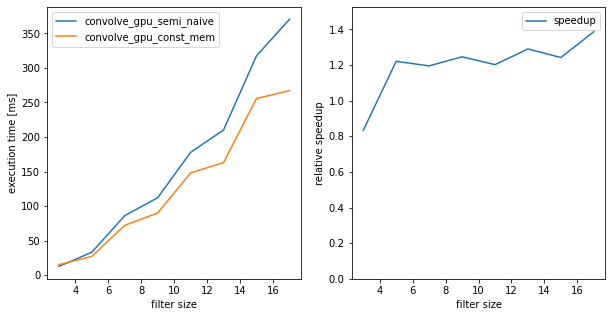

In [ ]:
image = read_image(image_path, 16)

# kernel execution settings
threads_per_block = (32, 32)

# confirm that the numba implementation return same result as scipy.signal.convolve2d(..., mode='valid')
filter = get_uniform_filter(size=3)
filtered_image = np.zeros_like(image)

blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

convolve_gpu_naive = construct_convolve_gpu_naive()
convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)

result = keep_valid_image(filtered_image, filter)
validate_result_against_scipy_implementation(result, image, filter)

# compare performance
filtered_image = np.zeros_like(image)

filter_sizes = [3, 5, 7, 9, 11, 13, 15, 17]

uniform_filters = [get_uniform_filter(size) for size in filter_sizes]

# copy data to device
stream = cuda.stream()
with timeit_context('Transfer time to GPU'):
    image_on_device = cuda.to_device(image, stream=stream)
    filter_on_device = cuda.to_device(filter, stream=stream)
    filtered_image_on_device = cuda.to_device(filtered_image, stream=stream)
    cuda.synchronize()


# time the semi-naive implementation
timeit_result = []
for filter in uniform_filters:
    filter_on_device = cuda.to_device(filter, stream=stream)
    cuda.synchronize()
    convolve_gpu_semi_naive = construct_convolve_gpu_semi_naive(image.shape, filter.shape)
    def execute(filter_arg):
        convolve_gpu_semi_naive[blocks_per_grid, threads_per_block](image_on_device, filter_arg, filtered_image_on_device)
        cuda.synchronize()
    timeit_result.append(timeit(lambda: execute(filter_on_device), repeats=3))
exec_times_convolve_gpu_semi_naive = np.array(timeit_result)


# time the implementation with constant memory
timeit_result = []
for filter in uniform_filters:
    convolve_gpu_const_mem = construct_convolve_gpu_const_mem(image.shape, filter)
    def execute():
        convolve_gpu_const_mem[blocks_per_grid, threads_per_block](image_on_device, filtered_image_on_device)
        cuda.synchronize()
    timeit_result.append(timeit(lambda: execute(), repeats=5))
exec_times_convolve_gpu_const_mem = np.array(timeit_result)

# plot comparison
plot_exec_times_comparison(filter_sizes,
                            exec_times_convolve_gpu_semi_naive, 'convolve_gpu_semi_naive',
                            exec_times_convolve_gpu_const_mem, 'convolve_gpu_const_mem')

Conclusions:
* Constant memory is assigned with the call `const_filter = cuda.const.array_like(filter)` within the CUDA-kernel. Here `filter` is an array in host-memory.
* Constant memory gives a performance improvement by storing the constant filter values in a cached region of the global memory.

### 7. CUDA kernel using shared memory for filter

About shared memory:
* Shared memory is a fast local memory inside each SM (on the order ~64KByte).
* It is accessible from all thread inside a single SM, but not between SMs.

Processing using shared memory is done in two steps:
* First the data is copied from global memory to shared memory.
* Then the calculation is done using the data in shared memory and output is written to global memory.

Note:
* Shared memory is well-suited for accelarting the convolution, since the calculation of neighboring threads/pixels access overlapping data-regions. Therefore data will be accessed multiple times. Storing data in shared memory helps avoid repeated reads form global memory.
* Besides the pixels of each thread in the thread-block, we need to copy additional *apron pixels* from the image to shared memory. These are needed to perform the convolution at the border of the shared image region. The size of the apron-pixels depends on the filter-size.

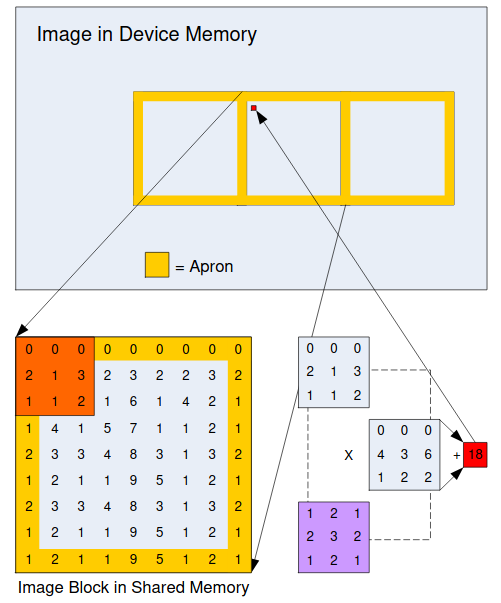

In [ ]:
def construct_convolve_gpu_shared_mem(image_shape, filter_shape, threads_per_block):
    # code is based on: https://www.vincent-lunot.com/post/an-introduction-to-cuda-in-python-part-5/

    image_height, image_width = image_shape

    image_height, image_width = image_shape

    filter_height, filter_width = filter_shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    filter_height = filter_shape[0]
    filter_width = filter_shape[1]

    mask_size = filter_height * filter_width

    shared_image_height = threads_per_block[0] + filter_height - 1
    shared_image_width = threads_per_block[1] + filter_width - 1
    shared_image_size = shared_image_height * shared_image_width

    delta_rows = filter_height // 2
    delta_cols = filter_width // 2

    @cuda.jit
    def convolve_gpu_shared_mem(image, mask, result):
        # expects a 2D grid and 2D blocks,
        # a mask with odd numbers of rows and columns,
        # a grayscale image

        # 2D coordinates of the current thread:
        row, col = cuda.grid(2)

        # Create shared, linear arrays
        shared_image = cuda.shared.array(shared_image_size, float32)
        shared_mask = cuda.shared.array(mask_size, float32)

        # Fill shared mask
        if (cuda.threadIdx.x < filter_height) and (cuda.threadIdx.y < filter_width):
            shared_mask[cuda.threadIdx.x + cuda.threadIdx.y * filter_height] = mask[cuda.threadIdx.x, cuda.threadIdx.y]

        # Fill shared image
        # Each thread fills four cells of the array
        row_corner = cuda.blockDim.x * cuda.blockIdx.x - delta_rows
        col_corner = cuda.blockDim.y * cuda.blockIdx.y - delta_cols
        even_idx_x = 2 * cuda.threadIdx.x
        even_idx_y = 2 * cuda.threadIdx.y
        odd_idx_x = even_idx_x + 1
        odd_idx_y = even_idx_y + 1
        for idx_x in (even_idx_x, odd_idx_x):
            if idx_x < shared_image_height:
                for idx_y in (even_idx_y, odd_idx_y):
                    if idx_y < shared_image_width:
                        point = (row_corner + idx_x, col_corner + idx_y)
                        if (point[0] >= 0) and (point[1] >= 0) and (point[0] < image_height) and (point[1] < image_width):
                            shared_image[idx_x + idx_y * shared_image_height] = image[point]
                        else:
                            shared_image[idx_x + idx_y * shared_image_height] = float32(0)
        cuda.syncthreads()

        # The result at coordinates (i, j) is equal to
        # sum_{k, l} mask[k, l] * image[threadIdx.x - k + 2 * delta_rows,
        #                               threadIdx.y - l + 2 * delta_cols]
        # with k and l going through the whole mask array:
        filtered_value = float32(0)
        for conv_index_x in range(filter_height):
            for conv_index_y in range(filter_width):
                imageCoord_x = cuda.threadIdx.x - conv_index_x + filter_height - 1
                imageCoord_y = cuda.threadIdx.y - conv_index_y + filter_width - 1
                filtered_value += shared_mask[conv_index_x + conv_index_y * filter_height] * shared_image[imageCoord_x + imageCoord_y * shared_image_height]

        if (row < image_height) and (col < image_width):
            result[row, col] = filtered_value

    return convolve_gpu_shared_mem

Compare performance of kernel with shared memory to semi-naive version:

Transfer time to GPU is 14.50 ms


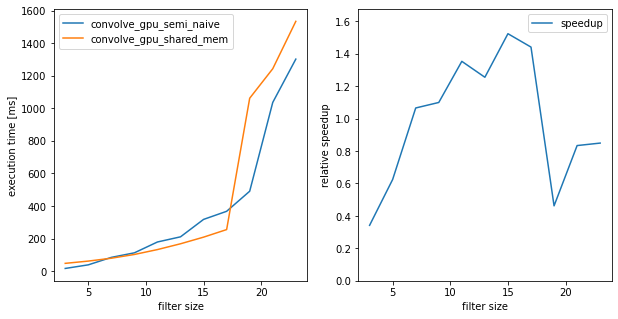

In [ ]:
image = read_image(image_path, 16)

# kernel execution settings
threads_per_block = (32, 32)

# confirm that the numba implementation return same result as scipy.signal.convolve2d(..., mode='valid')
filter = get_uniform_filter(size=3)
filtered_image = np.zeros_like(image)

blocks_per_grid = get_blocks_per_grid(threads_per_block, image.shape)

convolve_gpu_naive = construct_convolve_gpu_naive()
convolve_gpu_naive[blocks_per_grid, threads_per_block](image, filter, filtered_image)

result = keep_valid_image(filtered_image, filter)
validate_result_against_scipy_implementation(result, image, filter)

# compare performance
filtered_image = np.zeros_like(image)

filter_sizes = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]

uniform_filters = [get_uniform_filter(size) for size in filter_sizes]


stream = cuda.stream()
with timeit_context('Transfer time to GPU'):
    image_on_device = cuda.to_device(image, stream=stream)
    filter_on_device = cuda.to_device(filter, stream=stream)
    filtered_image_on_device = cuda.to_device(filtered_image, stream=stream)
    cuda.synchronize()


timeit_result = []
for filter in uniform_filters:
    filter_on_device = cuda.to_device(filter, stream=stream)
    cuda.synchronize()
    convolve_gpu_semi_naive = construct_convolve_gpu_semi_naive(image.shape, filter.shape)
    def execute(filter_arg):
        convolve_gpu_semi_naive[blocks_per_grid, threads_per_block](image_on_device, filter_arg, filtered_image_on_device)
        cuda.synchronize()
    timeit_result.append(timeit(lambda: execute(filter_on_device), repeats=3))
exec_times_convolve_gpu_semi_naive = np.array(timeit_result)


timeit_result = []
for filter in uniform_filters:
    filter_on_device = cuda.to_device(filter, stream=stream)
    cuda.synchronize()
    convolve_gpu_shared_mem = construct_convolve_gpu_shared_mem(image.shape, filter.shape, threads_per_block)
    def execute():
        convolve_gpu_shared_mem[blocks_per_grid, threads_per_block](image_on_device, filter_on_device, filtered_image_on_device)
        cuda.synchronize()
    timeit_result.append(timeit(lambda: execute(), repeats=3))
exec_times_convolve_gpu_shared_mem = np.array(timeit_result)


# plot comparison
plot_exec_times_comparison(filter_sizes,
                            exec_times_convolve_gpu_semi_naive, 'convolve_gpu_semi_naive',
                            exec_times_convolve_gpu_shared_mem, 'convolve_gpu_shared_mem')

Conclusions:

* Shared memory is fast and useful for:
  * storing data that is accessed repeatedly to alleviate memory bottlenecks.
  * storing intermediate results that are accessed from other threads.
* Limitations:
  * Not trivial to implement: speed-up depends on optimal usage for respective GPU.
  * Shared access is only possible within a SM/thread-block.
  * There is only a small amount of shared memory available per SM (amount depends on the GPU; e.g. 48KBytes on Pascal small architecture; 64KB for high-end). If that limit is reached, the execution falls back to local memory and performance can suffer significantly.

## 8. Resources

* Regarding convlution on the GPU:
  * [Nvidia documentation on 2D separable convolution](https://github.com/tpn/cuda-samples/blob/master/v11.0/3_Imaging/convolutionSeparable/doc/convolutionSeparable.pdf)
  * [A study of OpenCL image
convolution optimization](https://www.evl.uic.edu/kreda/gpu/image-convolution/)

* Links on using constant memory in numba.cuda:
  * https://stackoverflow.com/questions/63311574/in-numba-how-to-copy-an-array-into-constant-memory-when-targeting-cuda
  * https://github.com/numba/numba/issues/4057

* Link on memory optimization in GPUs:
  * https://www.paranumal.com/single-post/2018/02/26/basic-gpu-optimization-strategies
  * http://courses.cms.caltech.edu/cs179/2015_lectures/cs179_2015_lec05.pdf
  * [Discussion of different types of memory](https://www.microway.com/hpc-tech-tips/gpu-memory-types-performance-comparison/)

* Other:
  * [Introduction to GPU-programming](https://www.vincent-lunot.com/post/an-introduction-to-cuda-in-python-part-1/)